<a href="https://www.kaggle.com/code/surendrarathore26/sarcastic-news-headlines-detection?scriptVersionId=103198276" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from nltk.corpus import stopwords 
import re
import nltk
from wordcloud import WordCloud
nltk.download("stopwords")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
import optuna
import time

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Gather Data
News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). They collect real (and non-sarcastic) news headlines from HuffPost.

Each record consists of three attributes:
* is_sarcastic: 1 if the record is sarcastic otherwise 0
* headline: the headline of the news article
* article_link: link to the original news article. Useful in collecting supplementary data

In [3]:
data = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In this dataset there is not any null value and there is 28619 sentence.

In [4]:
print("Null Values\n",data.isnull().sum())
print("\nData Shape: " , data.shape)

Null Values
 is_sarcastic    0
headline        0
article_link    0
dtype: int64

Data Shape:  (28619, 3)


In [5]:
def find_num_words(data):
    wordlist = []
    splitting_list = data.str.split()
    for i in range(len(splitting_list)):
        for j in range(len(splitting_list[i])):
            wordlist.append(splitting_list[i][j])
            
    wordset = set(wordlist)
    
    print(len(wordset),len(wordlist))

find_num_words(data.headline)

38234 287620


# Visualization
In the first two visualization, we examine the distribution of real and fake data. First graph is a countplot from seaborn. It shows both real and fake news numbers with columnns. Second graph is a pie graph. If we use pie graph, we can examine percentages of distributions.

0    14985
1    13634
Name: is_sarcastic, dtype: int64 



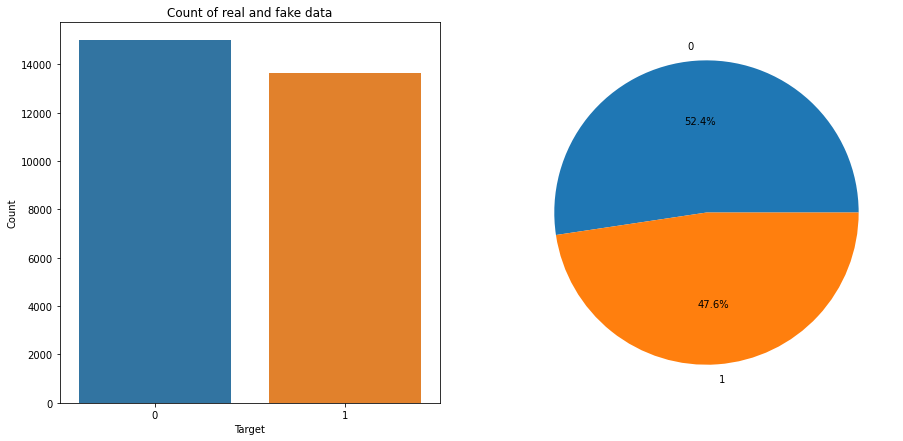

In [6]:
print(data.is_sarcastic.value_counts() ,"\n")

fig, ax = plt.subplots(1,2, figsize=(15, 7))
f1 = sns.countplot(data.is_sarcastic, ax = ax[0]);
f1.set_title("Count of real and fake data")
f1.set_ylabel("Count")
f1.set_xlabel("Target")

f2 = plt.pie(data["is_sarcastic"].value_counts().values,explode=[0,0],labels=data.is_sarcastic.value_counts().index, autopct='%1.1f%%')
fig.show()

In the graph below, we examined which sites the real and fake news were obtained from. We used urlparse to get the site name from url.

In [7]:
def get_netloc(url):
    scheme, netloc, path, params, query, fragment = urlparse(url)
    return netloc

link = []
for i in range(len(data.article_link)):
    link.append(get_netloc(data.article_link[i]))
    
data["link"] = link

In [8]:
data.link = data["link"].str.replace("local.theonion.com","www.theonion.com").replace("politics.theonion.com","www.theonion.com").replace("entertainment.theonion.com","www.theonion.com").replace("sports.theonion.com","www.theonion.com").replace("ogn.theonion.com","www.theonion.com")
data.link = data.link.str.replace('www.huffingtonpost.comhttp:','www.huffingtonpost.com').replace('www.huffingtonpost.comhttps:','www.huffingtonpost.com')
data.link.value_counts()

www.huffingtonpost.com    14985
www.theonion.com          13634
Name: link, dtype: int64

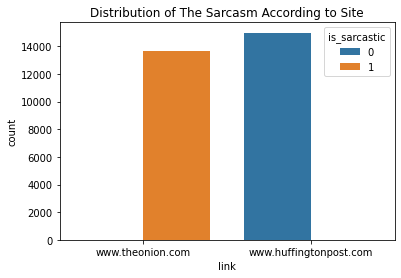

In [9]:
ax = sns.countplot(x="link",  hue='is_sarcastic', data=data,)
plt.title("Distribution of The Sarcasm According to Site");

# Preparing Data

In [10]:
#Removing punctiation marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing special characters
def remove_specialchars(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords and lemmatization
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)


#Total function
def cleaning(text):
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

data['headline']=data['headline'].apply(cleaning)

There are 1417022 words in the combination of all review.


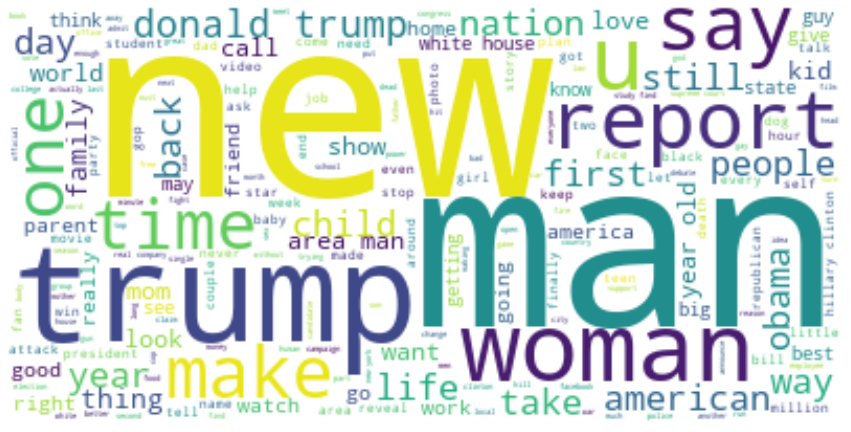

In [11]:
text = " ".join(review for review in data.headline)
print ("There are {} words in the combination of all review.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
data.head()

,is_sarcastic,headline,article_link,link
0,1,thirtysomething scientist unveil doomsday cloc...,https://www.theonion.com/thirtysomething-scien...,www.theonion.com
1,0,dem rep totally nail congress falling short ge...,https://www.huffingtonpost.com/entry/donna-edw...,www.huffingtonpost.com
2,0,eat veggie deliciously different recipe,https://www.huffingtonpost.com/entry/eat-your-...,www.huffingtonpost.com
3,1,inclement weather prevents liar getting work,https://local.theonion.com/inclement-weather-p...,www.theonion.com
4,1,mother come pretty close using word streaming ...,https://www.theonion.com/mother-comes-pretty-c...,www.theonion.com


## Tokenizing

In [13]:
sentences = data["headline"].values.tolist()
target = data["is_sarcastic"].values.tolist()

In [14]:
print(sentences[:2])
print(target[:2])

['thirtysomething scientist unveil doomsday clock hair loss', 'dem rep totally nail congress falling short gender racial equality']
[1, 0]


In [15]:
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(sentences)
tokens = tokenizer.texts_to_sequences(sentences)

numTokens = [len(token) for token in tokens]
numTokens = np.array(numTokens)
print("Tokens'mean",np.mean(numTokens))
print("Max", np.max(numTokens))
print("Argmax", np.argmax(numTokens))

Tokens'mean 3.7437017366085468
Max 31
Argmax 7302


In [16]:
#Longest one
sentences[7302]

'hot wheel ranked number one toy rolling ramp knocking domino send marble funnel dropping onto teeter totter yank string causing pulley system raise wooden block propelling series twine roller unwind spring launching tennis ball across room inching tire slope hit power switch activating table fan blow toy ship nail attached across kiddie pool popping water balloon fill cup weighing lever force basketball track nudging broomstick axis rotate allowing golf ball roll sideways coffee mug tumble row hardcover book handle catch hook attached lever cause wooden mallet slam serving spoon catapulting small ball cup attached ribbon lazy susan spin push battery incline plane tipping salt shaker season omelet'

In [17]:
max_tokens = int(np.mean(numTokens) + 2*np.std(numTokens))
print("Calculated maximum number of tokens :",max_tokens)
print("What percentage of the data fits this average? :",np.sum(numTokens < max_tokens) / len(numTokens))

Calculated maximum number of tokens : 7
What percentage of the data fits this average? : 0.9099898668716587


In [18]:
padding_data = pad_sequences(tokens, maxlen=max_tokens)
print(padding_data.shape)
print(len(target))

(28619, 7)
28619


# Model Building

In [19]:
X_train, X_test, y_train, y_test = train_test_split(padding_data, data.is_sarcastic, random_state=33, test_size=0.25, stratify=data.is_sarcastic)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=47, test_size=0.2, stratify=y_train)

In [20]:
def objective(trial):
    # Parameters
    L2 = trial.suggest_float("l", 1e-5, 1e-2, log=True)
    EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)
    BATCH_SIZE = trial.suggest_int("batch_size", 16, 64, step=8)
    EPOCHS = trial.suggest_int("epochs", 10,30, step=10)
    LR = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    OPT = trial.suggest_categorical("optimizer", [Adam, SGD, RMSprop])
    

    # Model
    """base_model = model(include_top=False, weights="imagenet", pooling="max")
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)"""
    
    model = Sequential()
    model.add(Embedding(input_dim = num_words,
                        output_dim=EMBEDDING_SIZE,
                        input_length=max_tokens,
                        name='embedding_layer'))
    
    model.add(GRU(units=128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=L2)))
    model.add(GRU(units=64,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=L2)))
    model.add(GRU(units=32,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=L2)))
    model.add(GRU(units=32))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))

 
    model.compile(optimizer=OPT(lr=LR), loss='binary_crossentropy', metrics=['accuracy'])

    H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

    val_loss, val_acc = model.evaluate(X_test,y_test)
    
    return val_loss # optuna değerlendirmesini en küçük değere göre yapıyor o yüzden loss döndürdüm. Accuracy döndürdüğümde acc büyüdükçe bunu kötü bir şeymiş gibi algıladı.


# Default Sampler is Tree-structured Parzen Estimator algorithm

study = optuna.create_study()
start = time.time()
study.optimize(objective, n_trials=5)
end = time.time()

[I 2022-08-13 10:24:41,785] A new study created in memory with name: no-name-cdbe7ccc-8cd7-4040-98c3-91f1b431f2e6


Epoch 1/20
358/358 [==============================] - 19s 32ms/step - loss: 0.7996 - accuracy: 0.5326 - val_loss: 0.6931 - val_accuracy: 0.5236
Epoch 2/20
358/358 [==============================] - 9s 26ms/step - loss: 0.6936 - accuracy: 0.5171 - val_loss: 0.6926 - val_accuracy: 0.5236
Epoch 3/20
358/358 [==============================] - 9s 25ms/step - loss: 0.6926 - accuracy: 0.5268 - val_loss: 0.6939 - val_accuracy: 0.5236
Epoch 4/20
358/358 [==============================] - 9s 26ms/step - loss: 0.6933 - accuracy: 0.5220 - val_loss: 0.6926 - val_accuracy: 0.5236
Epoch 5/20
358/358 [==============================] - 9s 26ms/step - loss: 0.6934 - accuracy: 0.5187 - val_loss: 0.6926 - val_accuracy: 0.5236
Epoch 6/20
358/358 [==============================] - 9s 26ms/step - loss: 0.6922 - accuracy: 0.5288 - val_loss: 0.6926 - val_accuracy: 0.5236
Epoch 7/20
358/358 [==============================] - 9s 26ms/step - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6927 - val_accuracy: 0.523

[I 2022-08-13 10:27:56,371] Trial 0 finished with value: 0.6926526427268982 and parameters: {'l': 0.004023274104482921, 'embedding_size': 40, 'batch_size': 48, 'epochs': 20, 'learning_rate': 0.0036509940983880107, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>}. Best is trial 0 with value: 0.6926526427268982.


Epoch 1/20
716/716 [==============================] - 23s 24ms/step - loss: 2.4579 - accuracy: 0.5042 - val_loss: 2.4541 - val_accuracy: 0.5236
Epoch 2/20
716/716 [==============================] - 15s 21ms/step - loss: 2.4529 - accuracy: 0.5218 - val_loss: 2.4491 - val_accuracy: 0.5236
Epoch 3/20
716/716 [==============================] - 16s 22ms/step - loss: 2.4477 - accuracy: 0.5285 - val_loss: 2.4440 - val_accuracy: 0.5236
Epoch 4/20
716/716 [==============================] - 15s 21ms/step - loss: 2.4429 - accuracy: 0.5157 - val_loss: 2.4390 - val_accuracy: 0.5236
Epoch 5/20
716/716 [==============================] - 15s 21ms/step - loss: 2.4379 - accuracy: 0.5193 - val_loss: 2.4340 - val_accuracy: 0.5236
Epoch 6/20
716/716 [==============================] - 15s 21ms/step - loss: 2.4327 - accuracy: 0.5291 - val_loss: 2.4291 - val_accuracy: 0.5236
Epoch 7/20
716/716 [==============================] - 15s 21ms/step - loss: 2.4279 - accuracy: 0.5212 - val_loss: 2.4241 - val_accuracy:

[I 2022-08-13 10:33:10,938] Trial 1 finished with value: 2.3614020347595215 and parameters: {'l': 0.0061614872080247175, 'embedding_size': 30, 'batch_size': 24, 'epochs': 20, 'learning_rate': 0.00015977719100745722, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}. Best is trial 0 with value: 0.6926526427268982.


Epoch 1/30
358/358 [==============================] - 17s 28ms/step - loss: 0.6976 - accuracy: 0.5086 - val_loss: 0.6976 - val_accuracy: 0.5241
Epoch 2/30
358/358 [==============================] - 8s 24ms/step - loss: 0.6976 - accuracy: 0.5262 - val_loss: 0.6976 - val_accuracy: 0.5236
Epoch 3/30
358/358 [==============================] - 9s 25ms/step - loss: 0.6976 - accuracy: 0.5224 - val_loss: 0.6976 - val_accuracy: 0.5236
Epoch 4/30
358/358 [==============================] - 8s 24ms/step - loss: 0.6976 - accuracy: 0.5235 - val_loss: 0.6975 - val_accuracy: 0.5236
Epoch 5/30
358/358 [==============================] - 8s 24ms/step - loss: 0.6975 - accuracy: 0.5257 - val_loss: 0.6975 - val_accuracy: 0.5236
Epoch 6/30
358/358 [==============================] - 9s 24ms/step - loss: 0.6975 - accuracy: 0.5250 - val_loss: 0.6975 - val_accuracy: 0.5236
Epoch 7/30
358/358 [==============================] - 9s 26ms/step - loss: 0.6975 - accuracy: 0.5173 - val_loss: 0.6974 - val_accuracy: 0.523

[I 2022-08-13 10:37:42,866] Trial 2 finished with value: 0.6969561576843262 and parameters: {'l': 1.8082834145721402e-05, 'embedding_size': 10, 'batch_size': 48, 'epochs': 30, 'learning_rate': 6.442448320198564e-05, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}. Best is trial 0 with value: 0.6926526427268982.


Epoch 1/10
307/307 [==============================] - 17s 31ms/step - loss: 0.6562 - accuracy: 0.6037 - val_loss: 0.5538 - val_accuracy: 0.7163
Epoch 2/10
307/307 [==============================] - 8s 26ms/step - loss: 0.5111 - accuracy: 0.7411 - val_loss: 0.5289 - val_accuracy: 0.7286
Epoch 3/10
307/307 [==============================] - 8s 27ms/step - loss: 0.5002 - accuracy: 0.7528 - val_loss: 0.5239 - val_accuracy: 0.7342
Epoch 4/10
307/307 [==============================] - 9s 28ms/step - loss: 0.4917 - accuracy: 0.7570 - val_loss: 0.5278 - val_accuracy: 0.7298
Epoch 5/10
307/307 [==============================] - 9s 28ms/step - loss: 0.4877 - accuracy: 0.7653 - val_loss: 0.5226 - val_accuracy: 0.7356
Epoch 6/10
307/307 [==============================] - 8s 27ms/step - loss: 0.4920 - accuracy: 0.7595 - val_loss: 0.5318 - val_accuracy: 0.7170
Epoch 7/10
307/307 [==============================] - 8s 27ms/step - loss: 0.4840 - accuracy: 0.7588 - val_loss: 0.5327 - val_accuracy: 0.734

[I 2022-08-13 10:39:18,249] Trial 3 finished with value: 0.535055935382843 and parameters: {'l': 6.710916248956863e-05, 'embedding_size': 10, 'batch_size': 56, 'epochs': 10, 'learning_rate': 0.0013303009414936035, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>}. Best is trial 3 with value: 0.535055935382843.


Epoch 1/10
716/716 [==============================] - 24s 24ms/step - loss: 0.7355 - accuracy: 0.5128 - val_loss: 0.7354 - val_accuracy: 0.5250
Epoch 2/10
716/716 [==============================] - 15s 21ms/step - loss: 0.7354 - accuracy: 0.5273 - val_loss: 0.7353 - val_accuracy: 0.5236
Epoch 3/10
716/716 [==============================] - 16s 22ms/step - loss: 0.7353 - accuracy: 0.5278 - val_loss: 0.7352 - val_accuracy: 0.5236
Epoch 4/10
716/716 [==============================] - 15s 21ms/step - loss: 0.7352 - accuracy: 0.5274 - val_loss: 0.7351 - val_accuracy: 0.5236
Epoch 5/10
716/716 [==============================] - 16s 23ms/step - loss: 0.7351 - accuracy: 0.5244 - val_loss: 0.7351 - val_accuracy: 0.5236
Epoch 6/10
716/716 [==============================] - 16s 22ms/step - loss: 0.7350 - accuracy: 0.5241 - val_loss: 0.7350 - val_accuracy: 0.5236
Epoch 7/10
716/716 [==============================] - 16s 22ms/step - loss: 0.7349 - accuracy: 0.5290 - val_loss: 0.7349 - val_accuracy:

[I 2022-08-13 10:42:08,375] Trial 4 finished with value: 0.734765350818634 and parameters: {'l': 0.0001581405991937628, 'embedding_size': 20, 'batch_size': 24, 'epochs': 10, 'learning_rate': 0.00021668638838594106, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}. Best is trial 3 with value: 0.535055935382843.


In [21]:
best_params = study.best_params
print(best_params)
print("model took %0.2f seconds to train" % (end - start))

{'l': 6.710916248956863e-05, 'embedding_size': 10, 'batch_size': 56, 'epochs': 10, 'learning_rate': 0.0013303009414936035, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>}
model took 1046.59 seconds to train


In [22]:
EMBEDDING_SIZE = 40

model = Sequential()
model.add(Embedding(input_dim = num_words,
                    output_dim=EMBEDDING_SIZE,
                    input_length=max_tokens,
                    name='embedding_layer'))
model.add(GRU(units=128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=1.367675698620851e-05)))
model.add(GRU(units=64,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=1.367675698620851e-05)))
model.add(GRU(units=32,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=1.367675698620851e-05)))
model.add(GRU(units=32))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 7, 40)             40000     
_________________________________________________________________
gru_20 (GRU)                 (None, 7, 128)            65280     
_________________________________________________________________
gru_21 (GRU)                 (None, 7, 64)             37248     
_________________________________________________________________
gru_22 (GRU)                 (None, 7, 32)             9408      
_________________________________________________________________
gru_23 (GRU)                 (None, 32)                6336      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                

In [23]:
model.compile(loss="binary_crossentropy", optimizer = RMSprop(lr=8.74355057651944e-05), metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=50)

Epoch 1/15
344/344 [==============================] - 19s 30ms/step - loss: 0.6961 - accuracy: 0.5398 - val_loss: 0.6868 - val_accuracy: 0.5597
Epoch 2/15
344/344 [==============================] - 9s 26ms/step - loss: 0.6723 - accuracy: 0.6171 - val_loss: 0.6398 - val_accuracy: 0.6175
Epoch 3/15
344/344 [==============================] - 10s 28ms/step - loss: 0.6087 - accuracy: 0.6870 - val_loss: 0.5834 - val_accuracy: 0.6904
Epoch 4/15
344/344 [==============================] - 10s 28ms/step - loss: 0.5628 - accuracy: 0.7123 - val_loss: 0.5600 - val_accuracy: 0.7144
Epoch 5/15
344/344 [==============================] - 9s 27ms/step - loss: 0.5285 - accuracy: 0.7365 - val_loss: 0.5509 - val_accuracy: 0.7198
Epoch 6/15
344/344 [==============================] - 10s 28ms/step - loss: 0.5160 - accuracy: 0.7388 - val_loss: 0.5517 - val_accuracy: 0.7184
Epoch 7/15
344/344 [==============================] - 10s 30ms/step - loss: 0.5077 - accuracy: 0.7450 - val_loss: 0.5390 - val_accuracy: 0

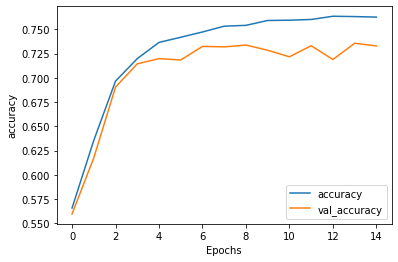

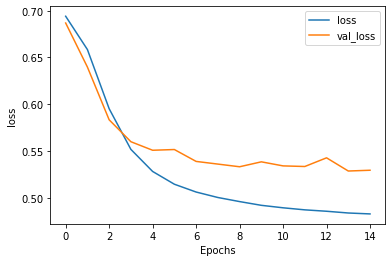

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')